<div style="font-size:35pt; font-weight:700;margin-top:50px;margin-bottom:50px;color:royalblue; text-align:center;width:800px;line-height:20pt">Kaggle Titanic Challenge</div>

This workbook is the titanic passenger dataset analysis to predict whether or not a passenger will survive from RMS Titanic disaster.

It is a Kaggle competition available <a href="https://www.kaggle.com/c/titanic" target="_blank">HERE</a>.

<i><blockquote><b>The Challenge</b></blockquote></i>
    
<blockquote>The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).</blockquote>
<figcaption>Kaggle</figcaption>

Note that this analysis is not extremely deep, it is intentionally simplified and some features are removed without further analysis for the sake of simplicity as I used the dataset to train at building a package and deploy an app online. The app is available <a href="https://titanic-survivor-vbnnt.herokuapp.com/" target="_blank">HERE</a>.

# 1. Import

In [1]:
# 
from scipy import stats
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight');

# Sci-kit learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config; set_config(display='diagram')

In [4]:
data = pd.read_csv("../raw_data/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Dropping useless features
<div style="font-weight:700">These features can't be used in algorithms: Tickets seems to be random, Names and PassengerId will not be used </div>

In [5]:
data = data.drop(["Name", "PassengerId", "Ticket"], axis=1)

# 3. Duplicates

In [6]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

107 duplicates were removed.


# 4. Missing
<div style="font-weight:700">Droping features that have too many missing values</div>

In [7]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

Cabin       74.107143
Age         13.520408
Embarked     0.255102
Fare         0.000000
Parch        0.000000
SibSp        0.000000
Sex          0.000000
Pclass       0.000000
Survived     0.000000
dtype: float64

<div style="font-weight:700">Cabin feature has 74% missing value, we remove it.</div>

In [8]:
data = data.drop(["Cabin"], axis=1)

In [9]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


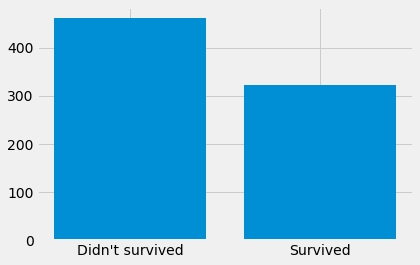

In [10]:
plt.bar(x=["Didn't survived", "Survived"], height=data["Survived"].value_counts());

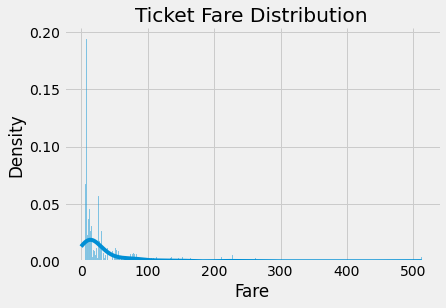

In [11]:
def plot_dist(series=data["Fare"], title="Ticket Fare Distribution"):
    sns.histplot(series, kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

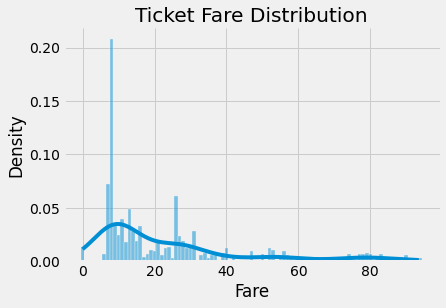

In [12]:
data = data[data["Fare"].between(0, 100)]
plot_dist(series=data["Fare"])

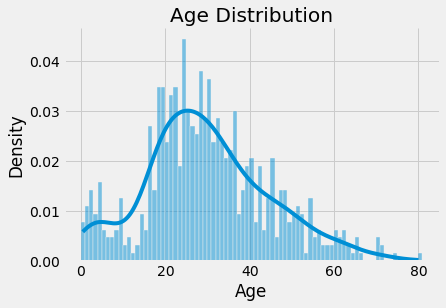

In [13]:
plot_dist(series=data["Age"], title="Age Distribution")

<div style="font-weight:700">As written at the beginning of the notebook, I remove some features with no further analyses.</div>

In [14]:
data = data.drop(["Embarked", "Parch", "SibSp"], axis=1)
data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


# 5. Preparing model inputs

In [15]:
X_train = data.drop(["Survived"], axis=1).copy()
y_train = data["Survived"].copy()

# 6. Pipelines

## Pipeline for numeric features

In [16]:
pipe_numeric = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean'))
])
pipe_numeric

Pipeline(steps=[('imputer', SimpleImputer())])

## Pipeline for multiclass features

In [17]:
pipe_multiclass = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(sparse=False))
])
pipe_multiclass

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(sparse=False))])

## Pipeline for binary features

In [18]:
pipe_binary = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, drop='if_binary'))
])
pipe_binary

Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary', sparse=False))])

## Impute and encode pipeline combination

In [19]:
impute_and_encode = ColumnTransformer([
    ('binary', pipe_binary, ["Sex"]),
    ('numeric', pipe_numeric, ["Age", "Fare"]),
    ('multiclass', pipe_multiclass, ["Pclass"])])
impute_and_encode

ColumnTransformer(transformers=[('binary',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 ['Sex']),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Age', 'Fare']),
                                ('multiclass',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['Pclass'])])

## Preprocessor pipeline

In [20]:
preprocessor = Pipeline([("preproc", impute_and_encode), 
                         ("scaler", StandardScaler())])

<div style="font-weight:700">Let's have an overview of the preprocessor pipeline output</div>

In [21]:
preprocessor.fit(X_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['Sex']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'Fare']),
                                                 ('multiclass',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass'])])),
                ('scaler', StandardScaler())])

<div style="font-weight:700">The output columns will be in the order of appearance in the ColumnTranformer pipe</div>

In [22]:
output_pipe_columns = ["Sex", "Age", "Fare", "Pclass1", "Pclass2", "Pclass3"]

In [23]:
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=output_pipe_columns)
X_train_scaled.head()

,Sex,Age,Fare,Pclass1,Pclass2,Pclass3
0,0.740762,-0.562605,-0.775565,-0.531466,-0.539925,0.897184
1,-1.349961,0.604880,2.249297,1.881588,-0.539925,-1.114599
2,-1.349961,-0.270734,-0.743679,-0.531466,-0.539925,0.897184
3,-1.349961,0.385976,1.390338,1.881588,-0.539925,-1.114599
4,0.740762,0.385976,-0.737774,-0.531466,-0.539925,0.897184


<div style="font-weight:700">Let's add a model to the pipeline: GradientBoostingClassifier</div>

In [24]:
final_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ('classifier', GradientBoostingClassifier())])
final_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preproc',
                                  ColumnTransformer(transformers=[('binary',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                  sparse=False))]),
                                                                   ['Sex']),
                                                                  ('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['Age',
                                                                    'Fare']),
                                                                  ('multiclass',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(sparse=False))]),
                                                                   ['Pclass'])])),
                                 ('scaler', StandardScaler())])),
                ('classifier', GradientBoostingClassifier())])

# 7. Baseline Accuracy for GradientBoostingClassifier

In [25]:
cv_baseline_GBC = cross_validate(final_pipe, X_train, y_train, scoring= "accuracy", cv=15)
print("Baseline gradient boosting classifier model accuracy: " + str(round(cv_baseline_GBC["test_score"].mean()*100, 2)) + "%")

Baseline gradient boosting classifier model accuracy: 80.31%


# 8. RandomizedSearchCV for an optimized model

In [54]:
grid_GBC = {'classifier__loss': ['exponential'],#, 'deviance'],
            'classifier__learning_rate': stats.loguniform(0.01, 1),
            'classifier__n_estimators': stats.randint(1, 500)
            }

search_GBC = RandomizedSearchCV(final_pipe,
                                grid_GBC,
                                scoring='accuracy',
                                n_iter=100,
                                cv=5,
                                n_jobs=-1,
                                verbose=True)

search_GBC.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [55]:
search_GBC.best_params_

{'classifier__learning_rate': 0.08245425472325657,
 'classifier__loss': 'exponential',
 'classifier__n_estimators': 306}

In [56]:
print("Tuned gradient boosting classifier model accuracy: " + str(round(search_GBC.best_score_*100, 2)) + "%")

Tuned gradient boosting classifier model accuracy: 80.72%
